In [39]:
#Se importan las librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#Se impotta MLFlow
import mlflow
import mlflow.keras


In [10]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


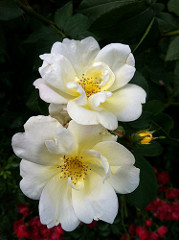

In [12]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

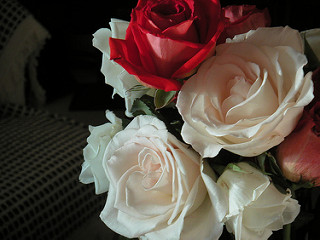

In [13]:
PIL.Image.open(str(roses[1]))

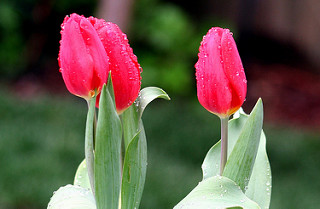

In [14]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

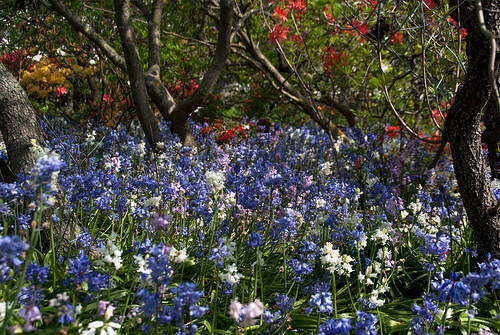

In [15]:
PIL.Image.open(str(tulips[1]))

In [16]:
# Se defienen los parametros para el cargado de las imagenes
batch_size = 32
img_height = 180
img_width = 180

In [17]:
# Se define el conjunto de entrenamiento y validacion
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [18]:
# Se define el conjunto de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
# Se definen las clases
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


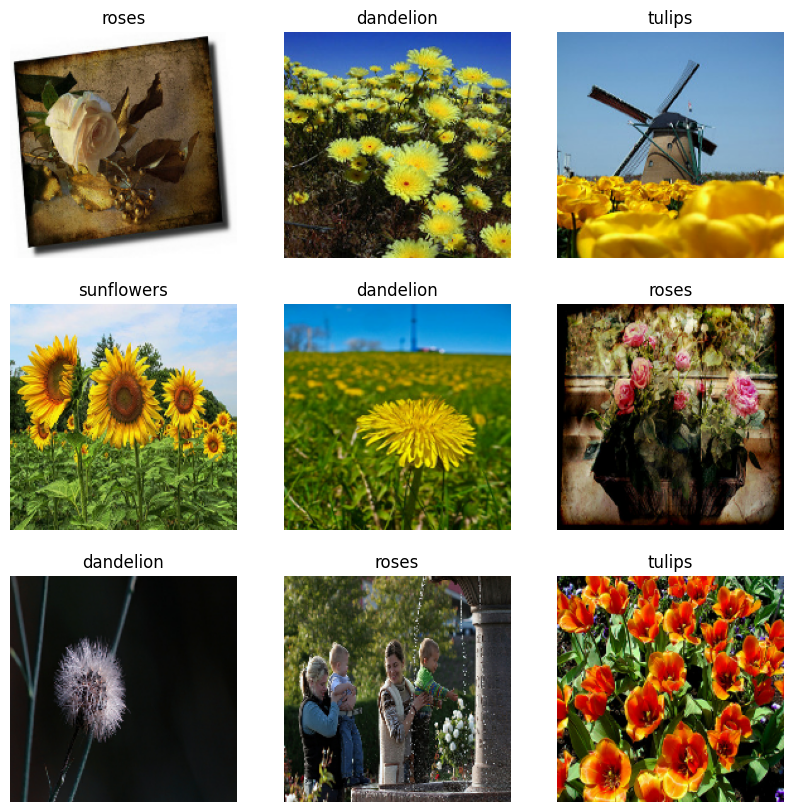

In [20]:
# Se visualizan las imagenes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
# Se precargan las imagenes, para mejorar la eficiencia
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# Se define la normalizacion de las imagenes
normalization_layer = layers.Rescaling(1./255)

In [24]:
# Se aplica la normalizacion a las imagenes
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9980883


In [25]:
# Se define el modelo
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\luiso\OneDrive\Documentos\GitHub\Frameworks_IA\frameworks_ai\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Se compila el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Se entrena el modelo
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.3692 - loss: 1.4547 - val_accuracy: 0.5627 - val_loss: 1.1030
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.6058 - loss: 0.9889 - val_accuracy: 0.6499 - val_loss: 0.8685
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7147 - loss: 0.7647 - val_accuracy: 0.6839 - val_loss: 0.8440
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7920 - loss: 0.5801 - val_accuracy: 0.6730 - val_loss: 0.8441
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.8751 - loss: 0.3699 - val_accuracy: 0.6594 - val_loss: 1.0491
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.9344 - loss: 0.2094 - val_accuracy: 0.6567 - val_loss: 1.1610
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.9606 - loss: 0.1282 - val_accuracy: 0.6839 - val_loss: 1.2829
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.9737 - loss: 0.0756 - val_accu

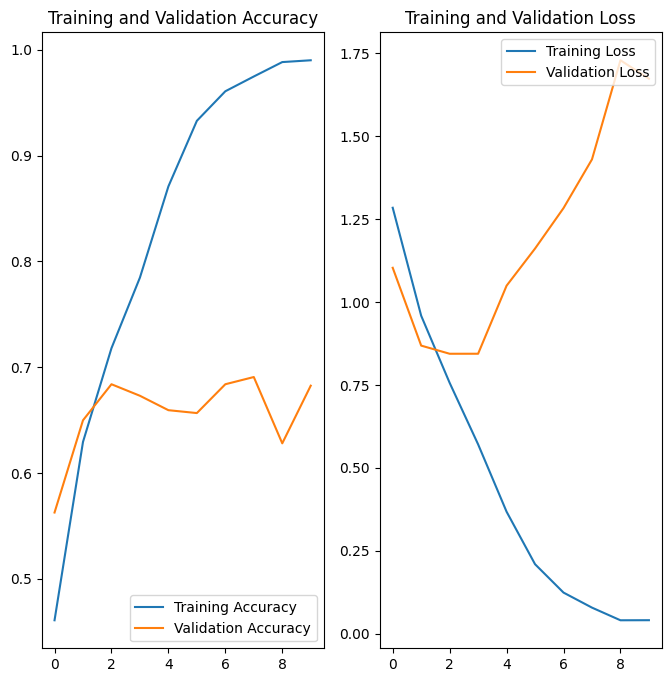

In [29]:
# Se visualizan los resultados de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

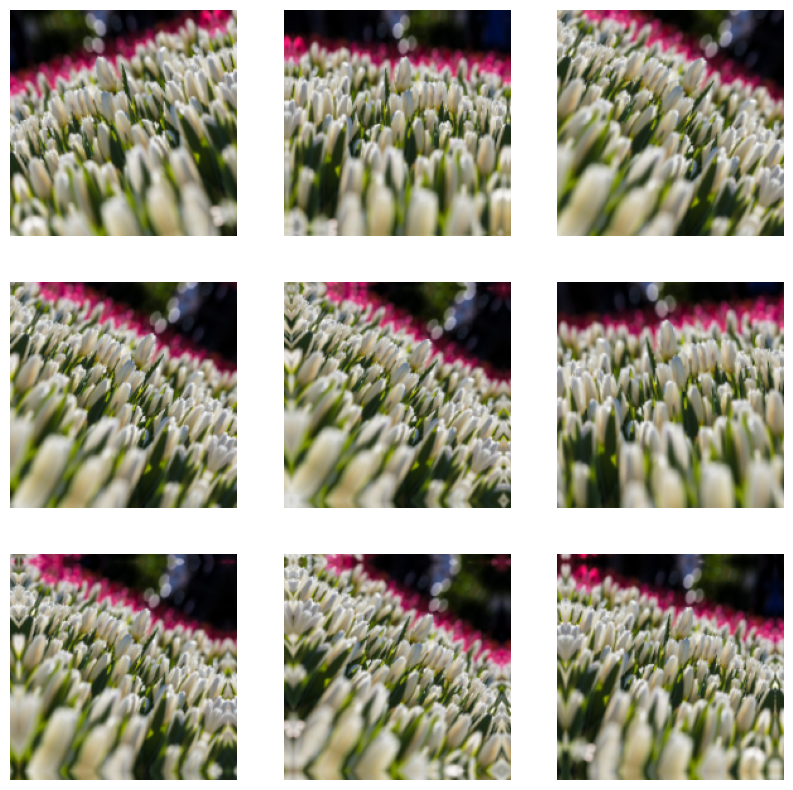

In [31]:
# Se visualizan las imagenes aumentadas
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
#Modelo con data augmentation y dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
# Se compila el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Se entrena el modelo
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.3091 - loss: 1.6079 - val_accuracy: 0.5654 - val_loss: 1.1409
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.5366 - loss: 1.1631 - val_accuracy: 0.5913 - val_loss: 1.0612
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5989 - loss: 1.0114 - val_accuracy: 0.5559 - val_loss: 1.1657
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6207 - loss: 0.9613 - val_accuracy: 0.6335 - val_loss: 0.9257
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6731 - loss: 0.8469 - val_accuracy: 0.6390 - val_loss: 0.9333
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6837 - loss: 0.8200 - val_accuracy: 0.6567 - val_loss: 0.8706
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6981 - loss: 0.7879 - val_accuracy: 0.6757 - val_loss: 0.8074
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.7087 - loss: 0.7631 - val_accu

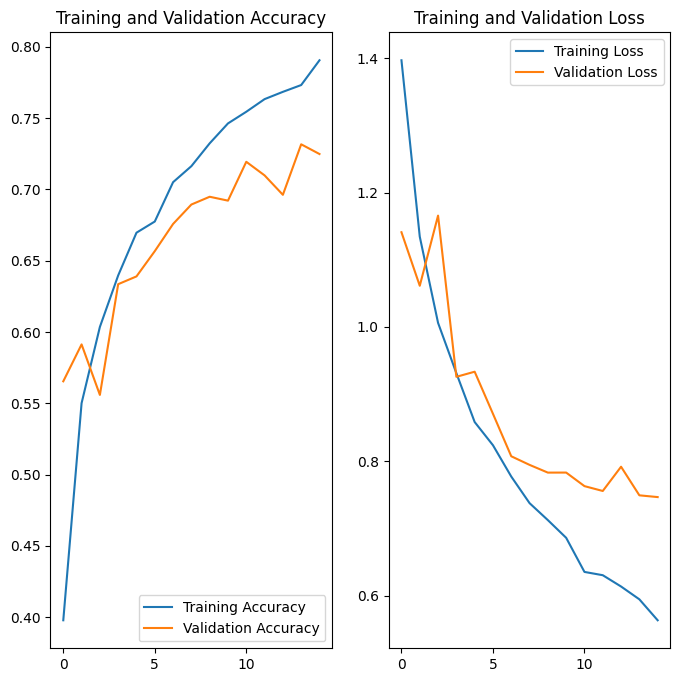

In [36]:
# Se visualizan los resultados de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# Se predice con nuevos datos
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
This image most likely belongs to sunflowers with a 99.77 percent confidence.


In [40]:
# Se definen los parametros para los experimentos de MLFlow
experimentos = [
    {"epochs": 10, "optimizer": "adam", "dropout_rate": 0.2},
    {"epochs": 15, "optimizer": "adam", "dropout_rate": 0.3},
    {"epochs": 20, "optimizer": "sgd", "dropout_rate": 0.2}
]

#Se configura el experimento
mlflow.set_experiment("ejercicio_1")

2024/08/25 17:44:53 INFO mlflow.tracking.fluent: Experiment with name 'ejercicio_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/luiso/OneDrive/Documentos/GitHub/Frameworks_IA/mlruns/423329097865627178', creation_time=1724622293672, experiment_id='423329097865627178', last_update_time=1724622293672, lifecycle_stage='active', name='ejercicio_1', tags={}>

In [42]:
# Se ejecutan los experimentos de MLFlow y se registran los resultados en la interfaz de MLFlow
for i, config in enumerate(experimentos):
    with mlflow.start_run(run_name=f"Experimento_{i+1}"):
        # Registrar parámetros
        mlflow.log_param("epochs", config["epochs"])
        mlflow.log_param("optimizer", config["optimizer"])
        mlflow.log_param("dropout_rate", config["dropout_rate"])

        # Se define el modelo
        model = Sequential([
            data_augmentation,
            layers.Rescaling(1./255),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(config["dropout_rate"]),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes)
        ])

        # Se compila el modelo
        model.compile(
            optimizer=config["optimizer"],
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        # Se entrena el modelo
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=config["epochs"]
        )

        # Se registran las métricas
        train_loss = history.history['loss'][-1]
        train_accuracy = history.history['accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        val_accuracy = history.history['val_accuracy'][-1]

        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_accuracy", val_accuracy)

        # Se muestran las métricas en consola
        print(f"\nResultados del Experimento {i+1}:")
        print(f"  Épocas: {config['epochs']}")
        print(f"  Optimizador: {config['optimizer']}")
        print(f"  Tasa de Dropout: {config['dropout_rate']}")
        print(f"  Pérdida en entrenamiento: {train_loss}")
        print(f"  Precisión en entrenamiento: {train_accuracy}")
        print(f"  Pérdida en validación: {val_loss}")
        print(f"  Precisión en validación: {val_accuracy}\n")

        # Se guarda el modelo
        mlflow.keras.log_model(model, "model")

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.2646 - loss: 1.7694 - val_accuracy: 0.4005 - val_loss: 1.3343
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.4985 - loss: 1.1886 - val_accuracy: 0.6063 - val_loss: 1.0340
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5849 - loss: 1.0429 - val_accuracy: 0.6022 - val_loss: 0.9684
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6072 - loss: 0.9756 - val_accuracy: 0.6240 - val_loss: 0.9522
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.6635 - loss: 0.8708 - val_accuracy: 0.6703 - val_loss: 0.8571
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.6842 - loss: 0.8415 - val_accuracy: 0.6689 - val_loss: 0.8449
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7111 - loss: 0.7657 - val_accuracy: 0.6649 - val_loss: 0.8515
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7117 - loss: 0.7664 - val_accu

2024/08/25 17:59:14 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



Resultados del Experimento 1:
  Épocas: 10
  Optimizador: adam
  Tasa de Dropout: 0.2
  Pérdida en entrenamiento: 0.6805969476699829
  Precisión en entrenamiento: 0.7414849996566772
  Pérdida en validación: 0.7664735913276672
  Precisión en validación: 0.692098081111908



2024/08/25 17:59:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.3924 - loss: 1.4050 - val_accuracy: 0.5000 - val_loss: 1.1534
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5660 - loss: 1.0685 - val_accuracy: 0.6035 - val_loss: 1.0351
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6456 - loss: 0.9125 - val_accuracy: 0.6553 - val_loss: 0.8742
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6626 - loss: 0.8442 - val_accuracy: 0.6499 - val_loss: 0.9432
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.6806 - loss: 0.8297 - val_accuracy: 0.6785 - val_loss: 0.8176
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.7065 - loss: 0.7836 - val_accuracy: 0.7003 - val_loss: 0.7510
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7344 - loss: 0.6969 - val_accuracy: 0.7098 - val_loss: 0.7628
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7428 - loss: 0.6736 - val_accu

2024/08/25 18:02:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



Resultados del Experimento 2:
  Épocas: 15
  Optimizador: adam
  Tasa de Dropout: 0.3
  Pérdida en entrenamiento: 0.5041768550872803
  Precisión en entrenamiento: 0.8065395355224609
  Pérdida en validación: 0.7057324647903442
  Precisión en validación: 0.747956395149231



2024/08/25 18:02:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.2689 - loss: 1.5602 - val_accuracy: 0.3706 - val_loss: 1.4457
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.3592 - loss: 1.4116 - val_accuracy: 0.4482 - val_loss: 1.2854
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.4375 - loss: 1.3206 - val_accuracy: 0.5245 - val_loss: 1.1738
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5108 - loss: 1.1813 - val_accuracy: 0.5313 - val_loss: 1.1104
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5429 - loss: 1.1216 - val_accuracy: 0.5640 - val_loss: 1.0869
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5684 - loss: 1.0822 - val_accuracy: 0.5395 - val_loss: 1.0895
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5838 - loss: 1.0560 - val_accuracy: 0.5804 - val_loss: 1.0236
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5893 - loss: 1.0528 - val_accuracy: 0.5831 - 

2024/08/25 18:05:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



Resultados del Experimento 3:
  Épocas: 20
  Optimizador: sgd
  Tasa de Dropout: 0.2
  Pérdida en entrenamiento: 0.8537415266036987
  Precisión en entrenamiento: 0.6679155230522156
  Pérdida en validación: 0.9021723866462708
  Precisión en validación: 0.640326976776123



2024/08/25 18:05:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Luego ejecuar mlflow ui""en terminal y abrir URL en navegador para ver los resultados en la interfaz de mlflow 
